<a href="https://colab.research.google.com/github/AlirezaSM/template-matching/blob/main/template_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/cplusx/QATM.git

fatal: destination path 'QATM' already exists and is not an empty directory.


In [ ]:
!7z x drive/MyDrive/Dataset.7z -o.


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 5359681573 bytes (5112 MiB)

Extracting archive: drive/MyDrive/Dataset.7z
--
Path = drive/MyDrive/Dataset.7z
Type = 7z
Physical Size = 5359681573
Headers Size = 279463
Method = LZMA2:24
Solid = +
Blocks = 3

  0%      0% 1        0% 11 - Dataset/Sample0004_Image.png                                        0% 12 - Dataset/Sample0004_Template.png                                           0% 23 - Dataset/Sample0008_Image.png                                        0% 35 -

# Using QATM for template matching

In [ ]:
from __future__ import print_function, division

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os, sys

In [ ]:
import keras
import tensorflow as tf
from keras.layers import Input, Lambda, Concatenate
from keras import Model
import keras.backend as K
from keras.applications.vgg16 import preprocess_input
from tqdm import tqdm
import random

In [ ]:
print(keras.__version__, tf.__version__)

2.9.0 2.9.2


In [ ]:
from QATM.models import QATM, MyNormLayer
from QATM.utils import compute_score, all_sample_iou, plot_success_curve

In [ ]:
file_dir = 'Dataset'
gt = sorted([ os.path.join(file_dir, i) for i in os.listdir(file_dir)  if '.txt' in i ])
img_path = sorted([ os.path.join(file_dir, i) for i in os.listdir(file_dir) if 'Image.png' in i ] )
tmp_path = sorted([ os.path.join(file_dir, i) for i in os.listdir(file_dir) if 'Template.png' in i ] )

temp = list(zip(gt, img_path, tmp_path))
random.seed(10)
random.shuffle(temp)
gt, img_path, tmp_path = zip(*temp)

gt = gt[:10]
img_path = img_path[:10]
tmp_path = tmp_path[:10]


def read_gt( file_path ):
    with open( file_path ) as IN:
        xmin, ymin, xmax, ymax = [ eval(i) for i in IN.readline().strip().split(',')]
        w = xmax - xmin
        h = ymax - ymin
    return xmin, ymin, w, h

In [ ]:
import numpy as np
from scipy import signal

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def the_corr(x):
    T_feat=np.array(x[0])
    k_feat=np.array(x[1])

#     # T_array = tf.make_ndarray(tf.make_tensor_proto(T_feat))
#     # k_array = tf.make_ndarray(tf.make_tensor_proto(k_feat))
#     T_array=T_feat.numpy()
#     corr = np.zeros_like(T_feat)

    scaler = MinMaxScaler()
    for i in range(T_feat.shape[3]):
       T_feat[0 ,: ,: ,i] = scaler.fit_transform(signal.correlate2d(T_feat[0 ,: ,: ,i], k_feat[0 ,: ,: ,i], boundary='fill', mode='same'))+0.75
    # T_feat = scaler.fit_transform(T_feat)
    return T_feat

In [ ]:
def find_keypart(template):
  #finding key point        
  candidate_size = (template.shape[0] // 2, template.shape[1] // 2)
  stride_size = (template.shape[0] // 4, template.shape[1] // 4)
  m = np.array([int(np.mean(template[...,0])), int(np.mean(template[...,1])), int(np.mean(template[...,2]))])
  
  start_point = [0, 0]
  min_value = 0
  min_index = [0, 0]
  
  for i in range(3):
      start_point[0] = i * stride_size[0]
      
      for j in range(3):
          start_point[1] = j * stride_size[1]
          candid = template.copy()
          candid[start_point[0]: start_point[0] + candidate_size[0], start_point[1]: start_point[1] + candidate_size[1]] = m
          i_product = sum(candid.reshape(-1)* template.reshape(-1))
          
          if i == 0 and j == 0:
              min_value = i_product
              
          if i_product < min_value:
              min_value = i_product
              min_index = [i, j]


  start_point[0] = min_index[0] * stride_size[0]
  start_point[1] = min_index[1] * stride_size[1]

  key = template.copy()
  key = key[start_point[0]: start_point[0] + candidate_size[0], start_point[1]: start_point[1] + candidate_size[1]]
  
  return key

In [ ]:
def create_model( featex, alpha = 1. ):
    T = Input( (None, None, 320), name='template_input' )
    I = Input( (None, None, 320), name='image_input' )   
    k = Input( (None, None, 320), name='key_input' )   
    
    T_feat = T
    I_feat = I
    
    # I_feat = featex(I)

    T_feat = tf.keras.layers.Multiply()([T_feat, k])
    # corr = np.zeros_like(T_feat)
    # for i in range(T_feat.shape[3]):
    #   corr[0,:,: ,i] = signal.correlate2d(T_feat[0 ,: ,: ,i], k_feat[0 ,: ,: ,i], boundary='symm', mode='same')

    # T_feat= T_feat *corr

    # T_feat = keras.layers.Lambda(the_corr)([T_feat,k_feat])



    I_feat, T_feat = MyNormLayer( name='norm_layer' )( [I_feat, T_feat] )
    dist = Lambda( lambda x: tf.einsum( "xabc,xdec->xabde", K.l2_normalize(x[0], axis=-1), K.l2_normalize(x[1], axis=-1) ) , name="cosine_dist")([ I_feat, T_feat ])
    conf_map = QATM(alpha, name='qatm')(dist)
    return Model( [T, I ,k], [conf_map], name='QATM_model' )
    
def model_eval( featex, alpha=1., backup=None ):
    '''
    Have a backup featex in case image is too big.
    '''
    model = create_model( featex , alpha=alpha)
    if backup is not None:
        model_bkup = create_model( backup , alpha=alpha)
    else:
        model_bkup = model
    gt_list, gray_list, score_list = [], [], []

    num_samples = len(img_path)
    # bar = progressbar.ProgressBar(max_value=num_samples)
    for idx in tqdm(range(num_samples)):
        # bar.update(idx + 1)
        # load image and ground truth
        template = cv2.imread( tmp_path[idx] )[...,::-1]
        image = cv2.imread( img_path[idx]) [...,::-1]
        image_gt = read_gt( gt[idx] )
        x_gt, y_gt, w_gt, h_gt = [int(round(t)) for t in image_gt]
        w = image.shape[0]
        h = image.shape[1]

        #finding key point        
        key = find_keypart(template)

        # preprocess images
        key_= np.expand_dims(preprocess_input( key ), axis=0)
        template_ = np.expand_dims(preprocess_input( template ), axis=0)
        image_ = np.expand_dims(preprocess_input( image ) , axis=0)

        # extract features
        # try:
        #   key_ = backup(key_)
        #   template_ = backup(template_)
        #   image_ = backup(image_)
        # except Exception as e:
        #   print('[EXCEPTION] feature extraction error: ', e)
        #   break
        
        # key_ = the_corr([template_, key_])
        # val = model.predict([template_, image_, key_])
        try:
          if w*h < 100000:
            print('Using normal network')

            key_= featex(key_)
            template_= featex(template_)
            image_ = featex(image_)

            key_=the_corr([template_,key_])

            val = model.predict( [template_, image_, key_ ] )
          else:
            # used when image is too big
            print('Using backup network')
            key_ = backup(key_)
            template_= backup(template_)
            image_ = backup(image_)

            key_=the_corr([template_,key_])

            val = model_bkup.predict( [template_, image_, key_] )
        
        except Exception as e:
          print(f'error index {idx}')
          print(e)
          break
        
        
        # compute geometry mean on score map
        val = np.log( val )
        gray = val[0,:,:,0]
        gray = cv2.resize( gray, (image.shape[1], image.shape[0]) )
        score = compute_score( gray, w_gt, h_gt )
        
        score[score>-1e-7] = -np.inf

        gt_list.append( image_gt )
        gray_list.append( gray )
        score_list.append( score )
    return score_list, gt_list, gray_list

In [ ]:
vgg19 = keras.applications.vgg19.VGG19( include_top = False, weights = 'imagenet' )

In [ ]:
# resize conv3_4 to conv1_2
input_ = vgg19.input
conv1_2 = vgg19.get_layer('block1_conv2').output
conv3_4 = vgg19.get_layer('block3_conv4').output
conv3_4 = Lambda( lambda x: tf.compat.v1.image.resize_bilinear( x[0], size=(tf.shape(x[1])[1], tf.shape(x[1])[2]), align_corners=True), name='resized_image' )( [conv3_4, conv1_2] )
concat = Concatenate()( [conv1_2, conv3_4] )
featex = Model( [input_], [concat], name='featex' )
# resize conv1_2 to conv3_4, used when image size is too big
input_ = vgg19.input
conv1_2 = vgg19.get_layer('block1_conv2').output
conv3_4 = vgg19.get_layer('block3_conv4').output
conv1_2 = Lambda( lambda x: tf.compat.v1.image.resize_bilinear( x[1], size=(tf.shape(x[0])[1], tf.shape(x[0])[2]), align_corners=True), name='resized_image' )( [conv3_4, conv1_2] )
concat = Concatenate()( [conv1_2, conv3_4] )
featex2 = Model( [input_], [concat], name='featex2' )

  0%|          | 0/10 [00:00<?, ?it/s]

Using backup network
1/1 [==============================] - 0s 308ms/step


 10%|█         | 1/10 [00:15<02:18, 15.41s/it]

Using backup network
1/1 [==============================] - 0s 381ms/step


 20%|██        | 2/10 [00:31<02:04, 15.59s/it]

Using normal network


 20%|██        | 2/10 [01:12<04:50, 36.28s/it]

error index 2
Graph execution error:

Detected at node 'QATM_model/qatm/Softmax_1' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 612, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 149, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py",

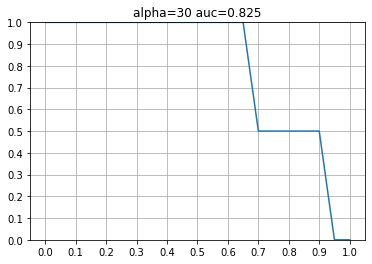

In [ ]:
for k in [30]:
    score_list, gt_list, gray_list = model_eval( featex, alpha=k, backup=featex2)
    iou_score = all_sample_iou( score_list, gt_list )
    plot_success_curve( iou_score, title='alpha={} '.format(k) )